# Spectrum of the preconditioned Hessian misfit operator
## The linear source inversion problem

We consider the following linear source inversion problem.
Find the state $u \in H^1_{\Gamma_D}(\Omega)$ and the source (*parameter*) $m \in H^1(\Omega)$ that solves

$$
\begin{aligned}
{} & \min_m \frac{1}{2\sigma^2} \| Bu - u_d \|^2 + \frac{1}{2} \int_\Omega \left[ \delta|m-m_0|^2 + \gamma|\nabla (m - m_0)|^2 \right] dx & {}\\
{\rm s.t.} & {} &{} \\
{} & -{\rm div}(k \nabla u) + {\bf v}\cdot \nabla u + cu = m & {\rm in} \; \Omega\\
{} & u = 0 & {\rm on } \; \Gamma_D\\
{} & k \frac{\partial u}{\partial n} = 0 & {\rm on } \; \Gamma_N\\
\end{aligned}
$$

Here:

- $u_d$ is a $n_{\rm obs}$ finite dimensional vector that denotes noisy observations of the state $u$ in $n_{\rm obs}$ locations $\{ {\bf x}_i\}_{i=1}^{n_{\rm obs}}$. Specifically, $u_d(i) = u_{\rm true}( {\bf x}_i ) + \eta_i$, where $\eta_i$ are i.i.d. $\mathcal{N}(0, \sigma^2)$.

- $B: H^1_0(\Omega) \rightarrow \mathbb{R}^{n_{\rm obs}}$ is the linear operator that evaluates the state $u$ at the observation locations $\{ {\bf x}_i\}_{i=1}^{n_{\rm obs}}$.

- $\delta$ and $\gamma$ are the parameters of the regularization penalizing the $L^2(\Omega)$ and $H^1(\Omega)$ norm of $m-m_0$, respectively.

- $k$, ${\bf v}$, $c$ are given coefficients representing the diffusivity coefficient, the advective velocity and the reaction term, respectively.

- $\Gamma_D \subset \partial \Omega$, $\Gamma_N \subset \partial \Omega$ represents the subdomain of $\partial\Omega$ where we impose Dirichlet or Neumann boundary conditions, respectively.



## 1. Load modules

In [1]:
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

from jacobian import Jacobian


import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

## 2. The linear source inversion problem

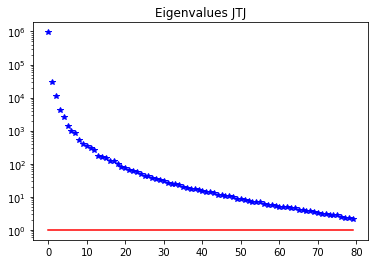

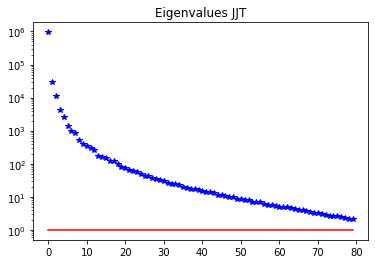

Difference in eigenvalues: 5.633692268610505e-07


In [2]:
k = dl.Constant(1.0)
v = dl.Constant((0.0, 0.0))
c = dl.Constant(0.)

def pde_varf(u,m,p):
    return k*dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx \
           + dl.inner(dl.nabla_grad(u), v*p)*dl.dx \
           + c*u*p*dl.dx \
           - m*p*dl.dx

def u_boundary(x, on_boundary):
    return on_boundary and x[1] < dl.DOLFIN_EPS

ndim = 2
nx = 32
ny = 32

ntargets = 300
np.random.seed(seed=1)
targets = np.random.uniform(0.1,0.9, [ntargets, ndim] )
rel_noise = 0.01

gamma = 70.
delta = 1e-1
verbose = False



myRandom = Random()
mesh = dl.UnitSquareMesh(nx, ny)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)

Vh = [Vh1, Vh1, Vh1]
if verbose:
    print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()) )


u_bdr = dl.Constant(0.0)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[STATE], u_bdr0, u_boundary)

mtrue = dl.interpolate( dl.Expression('min(0.5,exp(-100*(pow(x[0]-0.35,2) +  pow(x[1]-0.7,2))))',degree=5), Vh[PARAMETER]).vector()
m0 = dl.interpolate(dl.Constant(0.0), Vh[PARAMETER]).vector()

pde = PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

if verbose:
    print( "Number of observation points: {0}".format(targets.shape[0]) )

misfit = PointwiseStateObservation(Vh[STATE], targets)

reg = LaplacianPrior(Vh[PARAMETER], gamma, delta)

#Generate synthetic observations
utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
myRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

if verbose:
    plt.figure(figsize=(18,4))
    nb.plot(dl.Function(Vh[PARAMETER], mtrue), mytitle = "True source", subplot_loc=131)
    nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True state", subplot_loc=132)
    nb.plot_pts(targets, misfit.d,mytitle="Observations", subplot_loc=133)
    plt.show()

model = Model(pde, reg, misfit)
u = model.generate_vector(STATE)
m = m0.copy()
p = model.generate_vector(ADJOINT)
x = [u,m,p]
mg = model.generate_vector(PARAMETER)
model.solveFwd(u, x)
model.solveAdj(p, x)
model.evalGradientParameter(x, mg)
model.setPointForHessianEvaluations(x, gauss_newton_approx=True)

H = ReducedHessian(model)

solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner( reg.Rsolver )
solver.parameters["print_level"] = -1
solver.parameters["rel_tolerance"] = 1e-9
solver.solve(m, -mg)

if solver.converged:
    if verbose:
        print( "CG converged in ", solver.iter, " iterations." )
else:
    print( "CG did not converged." )
    raise

model.solveFwd(u, x)

total_cost, reg_cost, misfit_cost = model.cost(x)

    
J = Jacobian(model) 

class JTJ:
    def __init__(self,J):
        
        self.J = J
        
    def mult(self,x,y):
        self.J.JTJ(x,y)
        
JTJ_ = JTJ(J)

class JJT:
    def __init__(self,J):
        self.J = J
    
    def mult(self,x,y):
        self.J.JJT(x,y)

JJT_ = JJT(J)


if True:
    k_evec = 80
    p_evec = 5
    s = 2
    if verbose:
        print( "Double Pass Algorithm with H GN. Requested eigenvectors: {0}; Oversampling {1}.".format(k_evec,p_evec) )
    Omega = MultiVector(x[PARAMETER], k_evec+p_evec)
    myRandom.normal(1., Omega)

    
    lmbda_JTJ, V_JTJ = doublePass(JTJ_, Omega, k_evec,s, check = False)

    plt.figure()
    nb.plot_eigenvalues(lmbda_JTJ, mytitle="Eigenvalues JTJ")
#     nb.plot_eigenvectors(Vh[PARAMETER], V_JTJ, mytitle="Eigenvectors", which=[0,1,2,5,10,15])
    plt.show()
#     print('Difference in eigenvalues:', np.linalg.norm(lmbda_H_GN - lmbda_JTJ))
    
    obs_vector = dl.Vector()
    misfit.B.init_vector(obs_vector,0)
    Omega_u = MultiVector(obs_vector, k_evec+p_evec)
    myRandom.normal(1., Omega_u)
    

    lmbda_JJT, U_JJT = doublePass(JJT_, Omega_u, k_evec,s,check = False)

    
    plt.figure()
    nb.plot_eigenvalues(lmbda_JJT, mytitle="Eigenvalues JJT")
#     nb.plot_eigenvectors(Vh[PARAMETER], V_H_GN, mytitle="Eigenvectors", which=[0,1,2,5,10,15])
    plt.show()
    print('Difference in eigenvalues:', np.linalg.norm(lmbda_JJT - lmbda_JTJ)/np.linalg.norm(lmbda_JJT))

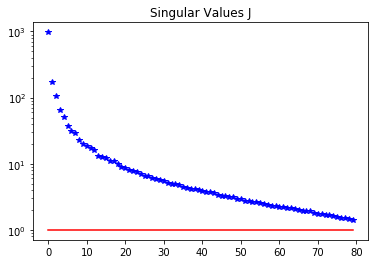

||sigma^2 - lambda|| =  6.92968667911183e-07


In [3]:


Omega = MultiVector(x[PARAMETER], k_evec+p_evec)
myRandom.normal(1., Omega)

# J.Bu.get_local().shape

U,d,V = accuracyEnhancedSVD(J,Omega,k_evec)



plt.figure()
nb.plot_eigenvalues(d, mytitle="Singular Values J")
#     nb.plot_eigenvectors(Vh[PARAMETER], V_H_GN, mytitle="Eigenvectors", which=[0,1,2,5,10,15])
plt.show()

print('||sigma^2 - lambda|| = ',np.linalg.norm(d**2 - lmbda_JJT)/np.linalg.norm(lmbda_JJT))




AttributeError: 'MultiVector' object has no attribute 'set_local'

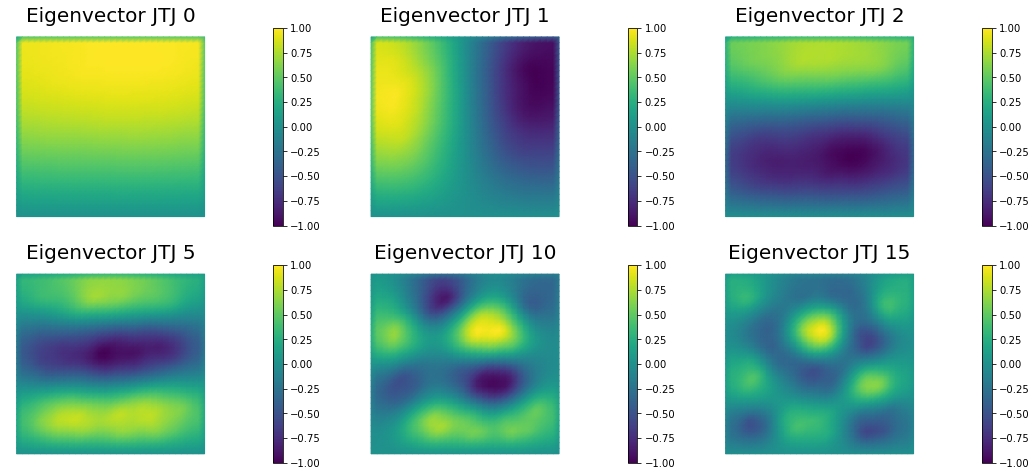

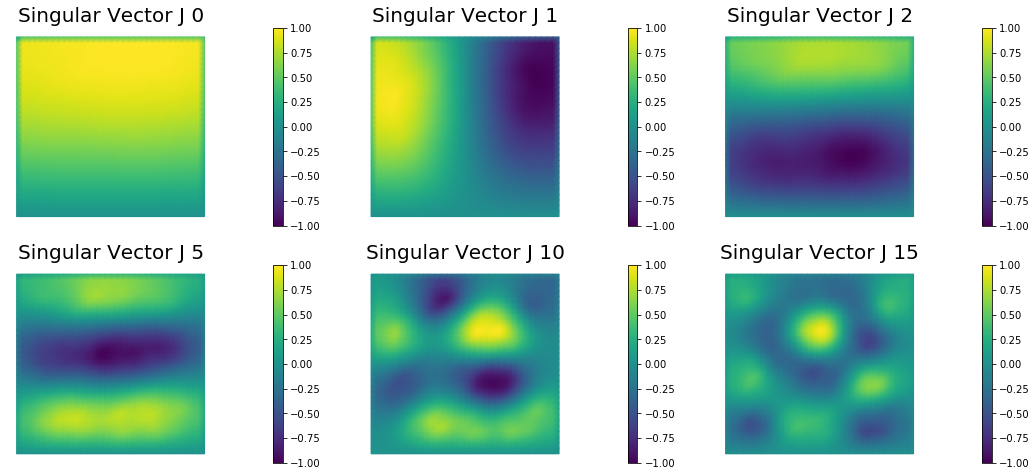

In [9]:
def MV_to_dense(multivector):
    multivector_shape = (multivector[0].get_local().shape[0],multivector.nvec())
    as_np_array = np.zeros(multivector_shape)
    for i in range(multivector_shape[-1]):
        temp = multivector[i].get_local()
        # print('For iteration i ||get_local|| = ', np.linalg.norm(temp))
        as_np_array[:,i] = temp

    return as_np_array

def dense_to_MV(dense_array,dl_vector):
    temp = MultiVector(dl_vector,dense_array.shape[-1])
    for i in range(temp.nvec()):
        temp[i].set_local(dense_array[:,i])
    return temp


def subtract_MV(mv_a,mv_b):
    
    temp = MultiVector(mv_a)
    for i in range(temp.nvec()):
        temp[i].add_local(-1.0*mv_b[i].get_local())
    return temp


# print('Eigenvectors of JTJ')
nb.plot_eigenvectors(Vh[PARAMETER], V_JTJ, mytitle="Eigenvector JTJ", which=[0,1,2,5,10,15])
# print('Right singular vectors of J')
nb.plot_eigenvectors(Vh[PARAMETER], V, mytitle="Singular Vector J", which=[0,1,2,5,10,15])


V_dense = MV_to_dense(V)

V_JTJ_dense = MV_to_dense(V_JTJ)

def compute_differences(U1,U2):
    assert U1.shape == U2.shape, 'Must pass in arrays with the same shapes'
    temp = np.zeros_like(U1)
    for i in range(U1.shape[-1]):
        plus_error = np.linalg.norm(U1[:,i]+U2[:,i])
        minus_error = np.linalg.norm(U1[:,i]- U2[:,i])
        if plus_error < minus_error:
            temp[:,i] = U1[:,i]+U2[:,i]
        else:
            temp[:,i] = U1[:,i]-U2[:,i]
    return temp
    

V_diff_dense = compute_differences(V_dense,V_JTJ_dense)

V_diff = dense_to_MV(V_diff_dense,V[0])

# print('Right singular vectors of J')
nb.plot_eigenvectors(Vh[PARAMETER], V_diff, mytitle="Difference", which=[0,1,2,5,10,15])
        


In [5]:

def compare_eigenvectors(U_1,U_2):
    U_1d = MV_to_dense(U_1)
    U_2d = MV_to_dense(U_2)
    print('||QTQ - I||',np.linalg.norm(np.dot(U_1d.T,U_2d) - np.eye(U_1d.shape[-1])))
    for i in range(U_1d.shape[-1]):
        error = min(np.linalg.norm(U_1d[:,i] - U_2d[:,i]),np.linalg.norm(U_1d[:,i] + U_2d[:,i]))
        print('i = ',i,' error = ',error)
    
print('Parameter space')
compare_eigenvectors(V,V_JTJ)
print('Observation space')
compare_eigenvectors(U,U_JJT)




Parameter space
||QTQ - I|| 12.569579787951854
i =  0  error =  5.329300658419798e-12
i =  1  error =  6.565192636426945e-09
i =  2  error =  4.74848160170714e-08
i =  3  error =  3.903618199669437e-07
i =  4  error =  1.3282397674291657e-06
i =  5  error =  2.919858482723598e-06
i =  6  error =  7.584273444522722e-06
i =  7  error =  1.2079020784899549e-05
i =  8  error =  2.7031520147879727e-05
i =  9  error =  3.138857810257495e-05
i =  10  error =  6.437218056039572e-05
i =  11  error =  7.88281769856425e-05
i =  12  error =  0.000124237311266907
i =  13  error =  0.00024999172499706073
i =  14  error =  0.0003577433343705879
i =  15  error =  0.0003139864212508724
i =  16  error =  0.00040133692410456936
i =  17  error =  0.0004968023094484864
i =  18  error =  0.0006686535280258294
i =  19  error =  0.0011995161719260392
i =  20  error =  0.001107248407402088
i =  21  error =  0.0018287426013403527
i =  22  error =  0.0020032607653132127
i =  23  error =  0.0015387920346938942
i 

In [7]:
class JT:
    def __init__(self,J):
        self.J = J
    def init_vector(self,x,dim):
        if dim == 0:
            self.J.init_vector(x,1)
        elif dim == 1:
            self.J.init_vector(x,0)
        else:
            raise
    def mult(self,x,y):
        self.J.transpmult(x,y)
    
    def transpmult(self,x,y):
        self.J.mult(x,y)
        
JT_ = JT(J)

obs_vector = dl.Vector()
misfit.B.init_vector(obs_vector,0)
Omega_u = MultiVector(obs_vector, k_evec+p_evec)
myRandom.normal(1., Omega_u)

# J.Bu.get_local().shape

V_JT,d_JT,U_JT = accuracyEnhancedSVD(JT_,Omega_u,k_evec)



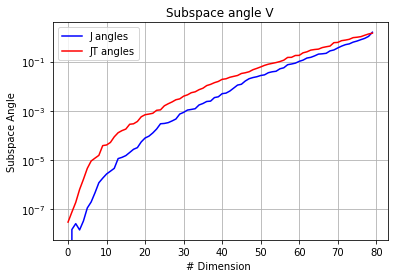

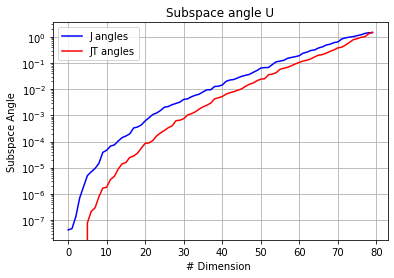

In [8]:
V_JTd = MV_to_dense(V_JT)


V_JT_angles = subspace_angles(V_JTd,V_JTJd)[::-1]

fig, ax = plt.subplots()
ax.semilogy(V_J_angles,'b-',label = 'J angles')
ax.semilogy(V_JT_angles,'r-',label = 'JT angles')

ax.set(xlabel='# Dimension ', ylabel='Subspace Angle',
       title='Subspace angle V')
ax.legend()
ax.grid()

U_JTd = MV_to_dense(U_JT)

U_JT_angles = subspace_angles(U_JTd,U_JJTd)[::-1]

fig, ax = plt.subplots()
ax.semilogy(U_J_angles,'b-',label = 'J angles')
ax.semilogy(U_JT_angles,'r-',label = 'JT angles')
ax.set(xlabel='# Dimension ', ylabel='Subspace Angle',
       title='Subspace angle U')
ax.legend()
ax.grid()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright (c) 2019, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.